<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

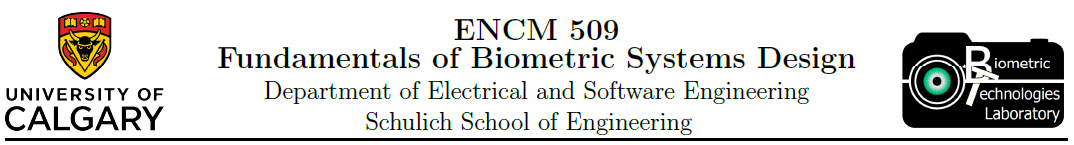

In [1]:
import os, random
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np

%matplotlib inline

r_seed = 101

# for reproducibility
# must to run this before create the BN! 
# Even in the cases where were changed the states names
gum.initRandom(r_seed) 
random.seed(r_seed)

## Example 1

In [2]:
# fast create a BN (random paramaters are chosen)
bn1 = gum.fastBN('Winter->Influenza;' + 
                'Winter->Cold;' +
                'Influenza->Fever<-Cold')

bn1

(pyAgrum.BayesNet<double>@0x2c0246a36d0) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}

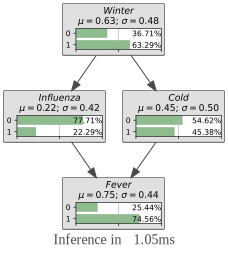

In [3]:
# Bayesian Network with random values
gnb.showInference(bn1)

### Populating the CPTs

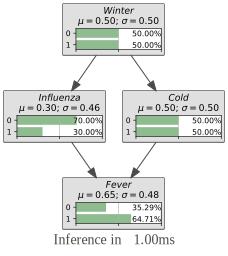

In [4]:
bn1.cpt('Winter')[:] = [0.5, 0.5]

bn1.cpt('Cold')[{'Winter':0}] = [0.8, 0.2]
bn1.cpt('Cold')[{'Winter':1}] = [0.2, 0.8]

bn1.cpt('Influenza')[{'Winter':0}] = [0.5, 0.5]
bn1.cpt('Influenza')[{'Winter':1}] = [0.9, 0.1] # should be [0.1, 0.9]

bn1.cpt('Fever')[{'Influenza':0, 'Cold':0}] = [1.0, 0.0]
bn1.cpt('Fever')[{'Influenza':0, 'Cold':1}] = [0.1, 0.9]
bn1.cpt('Fever')[{'Influenza':1, 'Cold':0}] = [0.1, 0.9]
bn1.cpt('Fever')[{'Influenza':1, 'Cold':1}] = [0.01, 0.99]

# inference without evidences
gnb.showInference(bn1)

In [5]:
bn1.cpt('Fever')

(pyAgrum.Potential<double>@0x2c01d4ada70) 
             ||  Fever            |
Influe|Cold  ||0        |1        |
------|------||---------|---------|
0     |0     || 1.0000  | 0.0000  |
1     |0     || 0.1000  | 0.9000  |
0     |1     || 0.1000  | 0.9000  |
1     |1     || 0.0100  | 0.9900  |

### Inference in the network

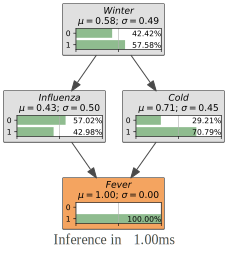

In [6]:
# evidence of Fever is True (1)
evidence = {'Fever': True}

# in PyAgrum two algorithms are available to do inference:
# - Lazy Propagation (default): gum.LazyPropagation(bn)
# - Variable Elimination: gum.VariableElimination(bn)
gnb.showInference(bn1, evs=evidence, engine=gum.LazyPropagation(bn1))

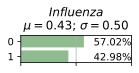

In [7]:
# calculate the updated value of prob. for Influenza
gnb.showPosterior(bn1, evidence, 'Influenza')

#### Other way to perform inferences

In [8]:
ie = gum.LazyPropagation(bn1)

ie.setEvidence(evidence)
ie.makeInference()

res_influenza = ie.posterior('Influenza')
res_influenza

(pyAgrum.Potential<double>@0x2c0246c29e0) 
  Influenza        |
0        |1        |
---------|---------|
 0.5702  | 0.4298  |

In [9]:
# calculating the probability that somebody has Influenza considering that he/she already has Fever
print('P(Influenza = True | Fever = True): %.4f%%' % (res_influenza[1] * 100))

P(Influenza = True | Fever = True): 42.9764%


### More Inference

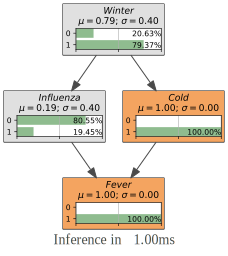

In [10]:
# adding a new evidence: Cold = True
evidence = {'Fever': True, 'Cold': True}

gnb.showInference(bn1, evs=evidence)

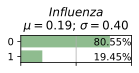

In [11]:
gnb.showPosterior(bn1, evidence, 'Influenza')

In [12]:
ie = gum.LazyPropagation(bn1)

ie.setEvidence(evidence)
ie.makeInference()

res_influenza = ie.posterior('Influenza')
print('P(Influenza = False | Fever = True, Cold = True): %.4f%%' % (res_influenza[0] * 100))

P(Influenza = False | Fever = True, Cold = True): 80.5501%


### Computing Joint Probability

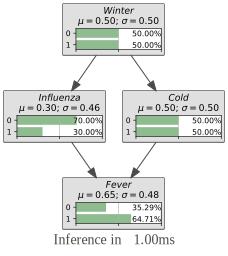

In [13]:
# no evidence
evidence = {}

# just to remind the BN
gnb.showInference(bn1, evs=evidence)

In [14]:
# Calculating the joint probability: Chain Rule
pICF = bn1.cpt('Influenza') * bn1.cpt('Cold') * bn1.cpt('Fever') * bn1.cpt('Winter')

# the result are all the possible scenarios
pICF

(pyAgrum.Potential<double>@0x2c0246c2760) 
                    ||  Winter           |
Cold  |Influe|Fever ||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.2000  | 0.0900  |
1     |0     |0     || 0.0050  | 0.0360  |
0     |1     |0     || 0.0200  | 0.0010  |
1     |1     |0     || 0.0005  | 0.0004  |
0     |0     |1     || 0.0000  | 0.0000  |
1     |0     |1     || 0.0450  | 0.3240  |
0     |1     |1     || 0.1800  | 0.0090  |
1     |1     |1     || 0.0495  | 0.0396  |

In [15]:
# In cases where Winter is "unknown" we can marginalize that variable
pICF = pICF.margSumOut(['Winter'])
pICF.normalize()

(pyAgrum.Potential<double>@0x2c0246c2720) 
             ||  Cold             |
Influe|Fever ||0        |1        |
------|------||---------|---------|
0     |0     || 0.2900  | 0.0410  |
1     |0     || 0.0210  | 0.0009  |
0     |1     || 0.0000  | 0.3690  |
1     |1     || 0.1890  | 0.0891  |

In [16]:
# the 1,0,0 in pICF corresponds to Fever=1, Influenza=0 and Cold=0
print('P(Fever = T, Influenza = F, Cold = F): %.4f%%' % (pICF[1,0,0] * 100))

P(Fever = T, Influenza = F, Cold = F): 0.0000%


In [17]:
# Converting to NumPy array when necessary
pICFa = pICF.toarray()
pICFa

array([[[0.29  , 0.041 ],
        [0.021 , 0.0009]],

       [[0.    , 0.369 ],
        [0.189 , 0.0891]]])

In [18]:
# checking the dimensions
pICFa.shape

(2, 2, 2)

## Example 2: Bayesian Network of Diamond Princess cruise ship

The Diamond Princess (DP) cruise ship became famous due to the COVID-19 outbreak on the beginning of 2020. https://en.wikipedia.org/wiki/COVID-19_pandemic_on_Diamond_Princess

The data used in this exercise is shown below: 

In [19]:
# male, female
gender = [55, 45]

# stratified data from JIID's report, 2020: https://www.niid.go.jp/niid/en/2019-ncov-e/9417-covid-dp-fe-02.html
age = [16, 23, 347, 428, 334, 398, 923, 1015, 216, 11]
age_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99']

In [20]:
bn = gum.fastBN('Age{0-9|10-19|20-29|30-39|40-49|50-59|60-69|70-79|80-89|90-99}->Susceptibility{low|medium|high};' +
                'Gender{male|female}->Susceptibility;')


gnb.sideBySide(bn, gnb.getInference(bn, size='30'))

G <!-- Age --> Age Age <!-- Susceptibility --> Susceptibility Susceptibility <!-- Age->Susceptibility --> Age->Susceptibility <!-- Gender --> Gender Gender <!-- Gender->Susceptibility --> Gender->Susceptibility


#### Defining the CPTs

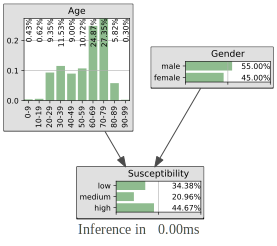

In [21]:
bn.cpt('Age')[:] = age / np.sum(age)
bn.cpt('Gender')[:] = gender / np.sum(gender)

# 0-9 yo, male: Susceptibility is 95% "low"
bn.cpt('Susceptibility')[{'Age':0, 'Gender':0}] = [.95, .05, .00]

# 0-9 yo, female: Susceptibility is 99% "low"
bn.cpt('Susceptibility')[{'Age':0, 'Gender':1}] = [.99, .01, .00]

# 90-99 yo, male: Susceptibility is 99% "high"
bn.cpt('Susceptibility')[{'Age':9, 'Gender':0}] = [.00, .01, .99]

# 90-99 yo, female: Susceptibility is 98% "high"
bn.cpt('Susceptibility')[{'Age':9, 'Gender':1}] = [.00, .02, .98]

# 40-49 yo, male: Susceptibility is 50% "high"
bn.cpt('Susceptibility')[{'Age':4, 'Gender':0}] = [.20, .30, .50]

# 40-49 yo, female: Susceptibility is 40% "medium"
bn.cpt('Susceptibility')[{'Age':4, 'Gender':1}] = [.30, .40, .30]

gnb.showInference(bn, size='30')

### Performing inference

#### Scenario 1

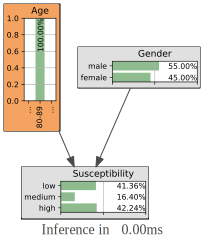

In [22]:
# considering a population of 80-89 years old, how susceptible they will be
evidence = {'Age':8}

ie = gum.LazyPropagation(bn)

ie.setEvidence(evidence)
ie.makeInference()

gnb.showInference(bn, size='10', evs=evidence)

In [23]:
res_susc = ie.posterior('Susceptibility')
res_susc

(pyAgrum.Potential<double>@0x2c01d4ad710) 
  Susceptibility             |
low      |medium   |high     |
---------|---------|---------|
 0.4136  | 0.1640  | 0.4224  |

In [24]:
print('P(Susceptibility = HIGH | Age = "80-89"): %.4f%%' % (res_susc[2] * 100))

P(Susceptibility = HIGH | Age = "80-89"): 42.2390%


#### Scenario 2

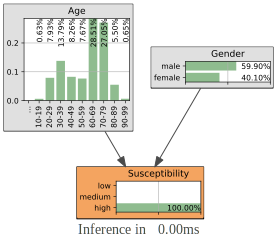

In [25]:
# if the ship population is Highly susceptible, which are the age groups most likely?
evidence = {'Susceptibility':2}

ie = gum.LazyPropagation(bn)

ie.setEvidence(evidence)
ie.makeInference()

gnb.showInference(bn, size='10', evs=evidence)

In [26]:
res_age = ie.posterior('Age')
res_age

(pyAgrum.Potential<double>@0x2c0246c2aa0) 
  Age                                                                                              |
0-9      |10-19    |20-29    |30-39    |40-49    |50-59    |60-69    |70-79    |80-89    |90-99    |
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
 0.0000  | 0.0063  | 0.0793  | 0.1379  | 0.0826  | 0.0767  | 0.2851  | 0.2705  | 0.0550  | 0.0065  |

In [27]:
res_age_a = res_age.toarray()
res_age_a

array([0.        , 0.0063168 , 0.07925195, 0.1379096 , 0.08261192,
       0.07667447, 0.28511412, 0.27054125, 0.05504014, 0.00653976])

In [28]:
max_idx = np.argmax(res_age_a)
max_perc = res_age_a[max_idx]*100
max_age = age_labels[max_idx]
print('With HIGH susceptibility, the age [%s] is the most likely with %.2f%%' % (max_age, max_perc))

With HIGH susceptibility, the age [60-69] is the most likely with 28.51%


#### Scenario 3

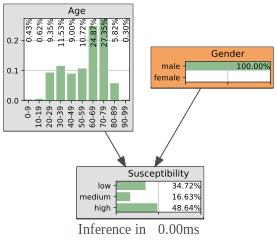

In [29]:
# considering only the male population
evidence = {'Gender':0}

ie = gum.LazyPropagation(bn)

ie.setEvidence(evidence)
ie.makeInference()

gnb.showInference(bn, size='10', evs=evidence)

In [30]:
# getting the posterior CPTs
res_age = ie.posterior('Age')
res_susc = ie.posterior('Susceptibility')

# manipulations to get the maximum value and percentage.
res_age_a = res_age.toarray() * 100
res_suc_a = res_susc.toarray() * 100

max_idx = np.argmax(res_age_a)
max_perc = res_age_a[max_idx]
max_age = age_labels[max_idx]

print('High susceptibility of %.2f%%, the age [%s] is the most likely with %.2f%%' % (res_suc_a[2], max_age, max_perc))

High susceptibility of 48.64%, the age [70-79] is the most likely with 27.35%


## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): Consider  Section 2.1.1 of Example 1. Perform calculations (by hand) of the probabilities that Influenza is True, and then that it is False, given the evidence that Fever is True. Compare the results to the ones calculated by PyAgrum.

- **Exercise 2** (3 marks): In  Section 2.1.3, PyAgrum was used to calculate the joint probability of Influenza, Cold and Fever. Repeat the same experiment for Fever, Cold and Winter. Next, do the calculations manually and compare to PyAgrym's results.

- **Exercise 3** (1 marks): In the CPTs for the BN of the Diamond Princess (Section 2.2.1), not all the entries of Susceptibility node were defined. Explain how many entries should be defined and what is the impact of having an incomplete CPT.    

- **Exercise 4** (3 marks): Using the BN of the Diamond Princess case, what will be the most likely the *Age* group of an individual given that this individual is  a male with 'high'  *Susceptibility*? Do the calculations  manually, and then compare against the Python's results. 